In [1]:
# A) CatBoost setup: load v2 data + NEW folds and init MLflow
import os, json, warnings, numpy as np, pandas as pd
from pathlib import Path
warnings.filterwarnings("ignore")

import mlflow
os.environ["MLFLOW_TRACKING_URI"] = "file:../mlruns"
mlflow.set_tracking_uri("file:../mlruns")
mlflow.set_experiment("houseprices_catboost")

DATA_DIR = Path("../data/")
PROCESSED_DIR = DATA_DIR / "processed"
ARTIFACTS_DIR = Path("../artifacts"); ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
OOF_DIR = ARTIFACTS_DIR / "oof"; OOF_DIR.mkdir(exist_ok=True)
SUB_DIR = ARTIFACTS_DIR / "submissions"; SUB_DIR.mkdir(exist_ok=True)

df_tr = pd.read_csv(PROCESSED_DIR / "hp_train_feat_v02.csv")
df_te = pd.read_csv(PROCESSED_DIR / "hp_test_feat_v02.csv")
with open(PROCESSED_DIR / "hp_clean_meta_v03.json","r") as f:
    meta = json.load(f)

# merge the new fold split
folds_df = pd.read_csv(PROCESSED_DIR / "cv_folds_strat_nbhd_price_v01.csv")
id_col, target_col = "Id", "SalePrice"
df_tr = df_tr.merge(folds_df, on=id_col, how="left")

feature_cols = [c for c in df_tr.columns if c not in [id_col, target_col, "fold"]]
y_log = np.log1p(df_tr[target_col]).astype(float)
X = df_tr[feature_cols].copy()
T = df_te[feature_cols].copy()
fold = df_tr["fold"].values

pd.DataFrame({"train_shape":[df_tr.shape], "test_shape":[df_te.shape], "n_features":[len(feature_cols)]})

2025/08/21 20:51:03 INFO mlflow.tracking.fluent: Experiment with name 'houseprices_catboost' does not exist. Creating a new experiment.


,train_shape,test_shape,n_features
0,"(1458, 134)","(1459, 133)",131


In [2]:
# B) Identify categorical columns for CatBoost (pass as names)
nominal_cols = set(meta.get("nominal_cols_final", [])) | set(meta.get("engineered_nominal", [])) \
               | {"Nbhd_Qual_cat_v2","Nbhd_Decade_cat_v2","NbhdCluster4_v2"}

cat_features = [c for c in nominal_cols if c in X.columns]
# CatBoost is happy with object/category; ensure dtype compatibility (strings fine too)
for c in cat_features:
    X[c] = X[c].astype("category")
    T[c] = T[c].astype("category")

num_features = [c for c in feature_cols if c not in cat_features]
pd.DataFrame({"n_cat":[len(cat_features)], "n_num":[len(num_features)], "sample_cat":[[cat_features[:10]]]})

,n_cat,n_num,sample_cat
0,36,95,"[[MSZoning, Condition2, BldgType, LandContour,..."


In [5]:
# Inspect missing in categorical features
na_counts = X[cat_features].isna().sum().sort_values(ascending=False)
na_counts.head(20)

MiscFeature         1404
Alley               1367
Fence               1177
MasVnrType           874
GarageType            81
GarageFinish          81
MSZoning               0
Foundation             0
SaleCondition          0
LandSlope              0
Condition1             0
Exterior2nd            0
RoofMatl               0
Nbhd_Qual_cat_v2       0
HouseStyle             0
Exterior1st            0
Electrical             0
SaleType               0
NbhdCluster4_v2        0
PavedDrive             0
dtype: int64

In [6]:
# Convert ALL categorical columns to string labels; replace NaN with a token
missing_token = "Missing"

def to_cat_strings(df, cols, token="Missing"):
    for c in cols:
        # keep as object, fill NaN, then cast to str
        df[c] = df[c].astype("object")
        df[c] = df[c].where(df[c].notna(), token)
        df[c] = df[c].astype(str)
    return df

X = to_cat_strings(X, cat_features, missing_token)
T = to_cat_strings(T, cat_features, missing_token)

# Sanity: no NaNs in cat features
X[cat_features].isna().sum().sum(), T[cat_features].isna().sum().sum()

(np.int64(0), np.int64(0))

In [7]:
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error
import numpy as np, pandas as pd

# Indices are safer than names
cat_idx = [X.columns.get_loc(c) for c in cat_features]

cb_params = dict(
    loss_function="RMSE",
    iterations=20000,
    learning_rate=0.03,
    depth=8,
    l2_leaf_reg=3.0,
    subsample=0.8,
    random_seed=42,
    eval_metric="RMSE",
    od_type="Iter",
    od_wait=200,
    allow_writing_files=False,
    verbose=False,
)

oof = np.zeros(len(df_tr), dtype=float)
test_folds = []
fold_scores = []
feat_imps = []

for k in sorted(np.unique(fold)):
    tr_idx = np.where(fold != k)[0]
    va_idx = np.where(fold == k)[0]

    train_pool = Pool(X.iloc[tr_idx], label=y_log.iloc[tr_idx], cat_features=cat_idx)
    valid_pool = Pool(X.iloc[va_idx], label=y_log.iloc[va_idx], cat_features=cat_idx)
    test_pool  = Pool(T, cat_features=cat_idx)

    model = CatBoostRegressor(**cb_params)
    model.fit(train_pool, eval_set=valid_pool, use_best_model=True)

    pred_va = model.predict(valid_pool)
    oof[va_idx] = pred_va
    fold_scores.append(float(np.sqrt(mean_squared_error(y_log.iloc[va_idx], pred_va))))

    test_folds.append(model.predict(test_pool))

    fi_vals = model.get_feature_importance(train_pool, type="FeatureImportance")
    feat_imps.append(pd.DataFrame({"feature": X.columns, "importance": fi_vals, "fold": int(k)}))

cv = pd.DataFrame({"fold": sorted(np.unique(fold)), "rmse": fold_scores})
cv.assign(cv_mean=float(np.mean(fold_scores)), cv_std=float(np.std(fold_scores)))

,fold,rmse,cv_mean,cv_std
0,0,0.107537,0.116045,0.009518
1,1,0.108509,0.116045,0.009518
2,2,0.132855,0.116045,0.009518
3,3,0.120187,0.116045,0.009518
4,4,0.111140,0.116045,0.009518


In [8]:
# D) Save CatBoost artifacts + MLflow log
run_tag = "cat_v02_baseline_nbhdstrat"

oof_path = OOF_DIR / f"{run_tag}_oof.csv"
sub_path = SUB_DIR / f"{run_tag}.csv"
imp_path = ARTIFACTS_DIR / f"{run_tag}_feat_importance.csv"

pd.DataFrame({id_col: df_tr[id_col].values, "pred_log": oof}).to_csv(oof_path, index=False)

test_mean = np.column_stack(test_folds).mean(axis=1)
pd.DataFrame({id_col: df_te[id_col].values, "SalePrice": np.expm1(test_mean)}).to_csv(sub_path, index=False)

fi_df = pd.concat(feat_imps, ignore_index=True)
fi_agg = fi_df.groupby("feature", as_index=False)["importance"].mean().sort_values("importance", ascending=False)
fi_agg.to_csv(imp_path, index=False)

cv_mean = float(np.mean(fold_scores)); cv_std = float(np.std(fold_scores))
with mlflow.start_run(run_name=run_tag):
    mlflow.log_params(cb_params)
    mlflow.log_param("feature_version", "v02")
    mlflow.log_param("folds_file", str(PROCESSED_DIR / "cv_folds_strat_nbhd_price_v01.csv"))
    mlflow.log_metric("cv_rmse_mean_log", cv_mean)
    mlflow.log_metric("cv_rmse_std_log",  cv_std)
    for r in cv.itertuples(index=False):
        mlflow.log_metric(f"fold{int(r.fold)}_rmse_log", float(r.rmse))
    mlflow.log_artifact(str(oof_path))
    mlflow.log_artifact(str(sub_path))
    mlflow.log_artifact(str(imp_path))

pd.DataFrame({"cv_rmse_mean_log":[cv_mean], "cv_rmse_std_log":[cv_std],
              "oof":[str(oof_path)], "submission":[str(sub_path)]})

,cv_rmse_mean_log,cv_rmse_std_log,oof,submission
0,0.116045,0.009518,../artifacts/oof/cat_v02_baseline_nbhdstrat_oo...,../artifacts/submissions/cat_v02_baseline_nbhd...


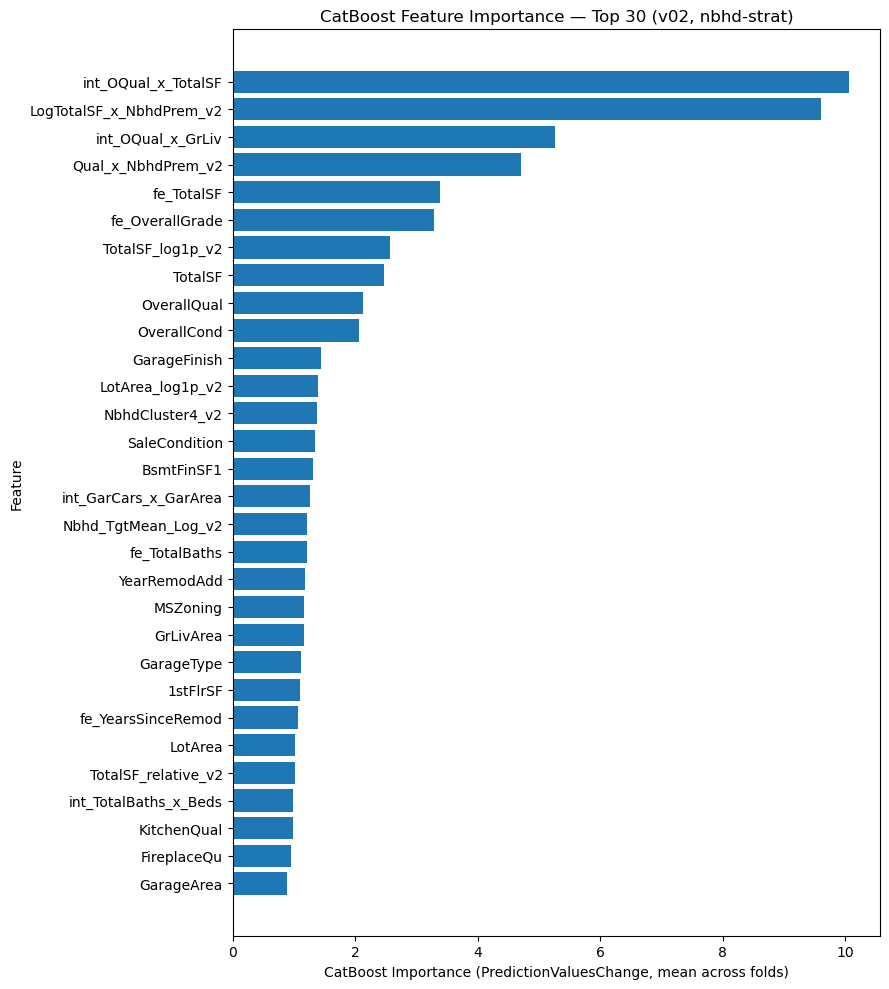

In [9]:
# E) (Optional) Importance plot — Top-30
import matplotlib.pyplot as plt, numpy as np

topk = 30
top = fi_agg.head(topk).sort_values("importance", ascending=True)

fig = plt.figure(figsize=(9, 10))
plt.barh(top["feature"], top["importance"])
plt.xlabel("CatBoost Importance (PredictionValuesChange, mean across folds)")
plt.ylabel("Feature")
plt.title(f"CatBoost Feature Importance — Top {topk} (v02, nbhd-strat)")
plt.tight_layout()
fig_path = ARTIFACTS_DIR / f"{run_tag}_feat_importance_top{topk}.png"
plt.savefig(fig_path, dpi=200, bbox_inches="tight"); plt.show()

In [10]:
# F) Convex stack (weights sum=1, >=0) on LOG OOFs: LGBM + XGB + Cat (ALL on nbhdstrat folds)
import numpy as np, pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error

ARTIFACTS_DIR = Path("../artifacts"); OOF_DIR = ARTIFACTS_DIR / "oof"; SUB_DIR = ARTIFACTS_DIR / "submissions"

oofs = {
    "lgbm_v02_baseline_nbhdstrat": OOF_DIR / "lgbm_v02_baseline_nbhdstrat_oof.csv",
    "xgb_v02_baseline_nbhdstrat":  OOF_DIR / "xgb_v02_baseline_nbhdstrat_oof.csv",
    "cat_v02_baseline_nbhdstrat":  OOF_DIR / "cat_v02_baseline_nbhdstrat_oof.csv",
}
subs = {
    k: SUB_DIR / (k.replace("_oof","") + ".csv") if str(v).endswith("_oof.csv")
       else SUB_DIR / (k + ".csv") for k,v in oofs.items()
}
# Load and inner-join OOFs by Id
parts = []
names = []
for name, path in oofs.items():
    if path.exists():
        dfp = pd.read_csv(path).rename(columns={"pred_log": name})
        parts.append(dfp[["Id", name]])
        names.append(name)
oof_mat = parts[0]
for dfp in parts[1:]:
    oof_mat = oof_mat.merge(dfp, on="Id", how="inner")

# Align y by Id
df_tr_y = pd.read_csv(PROCESSED_DIR / "hp_train_feat_v02.csv", usecols=["Id","SalePrice"])
df_tr_y["y_log"] = np.log1p(df_tr_y["SalePrice"])
y = oof_mat.merge(df_tr_y, on="Id", how="left")["y_log"].values
X = oof_mat[names].to_numpy()

# grid search convex weights (0.0..1.0 step 0.05)
grid = np.arange(0.0, 1.0+1e-9, 0.05)
best = (None, 1e9)
for w1 in grid:
    for w2 in grid:
        w3 = 1.0 - w1 - w2
        if w3 < 0 or w3 > 1: 
            continue
        W = np.array([w1, w2, w3])[:len(names)]
        pred = X.dot(W)
        rmse = float(np.sqrt(mean_squared_error(y, pred)))
        if rmse < best[1]:
            best = (W.copy(), rmse)

best_w, best_rmse = best
blend_table = pd.DataFrame({"model": names, "weight": best_w})
blend_table, pd.Series({"cv_rmse_log_stack_convex": best_rmse})

(                         model  weight
 0  lgbm_v02_baseline_nbhdstrat    0.20
 1   xgb_v02_baseline_nbhdstrat    0.15
 2   cat_v02_baseline_nbhdstrat    0.65,
 cv_rmse_log_stack_convex    0.115444
 dtype: float64)

In [11]:
# G) Build stacked submission with the chosen convex weights (log domain → expm1)
subs_parts = []
for name in names:
    dfp = pd.read_csv(SUB_DIR / f"{name}.csv").sort_values("Id")
    dfp["logp"] = np.log1p(dfp["SalePrice"])
    subs_parts.append(dfp[["Id","logp"]].rename(columns={"logp": f"logp_{name}"}))

sub_mat = subs_parts[0]
for dfp in subs_parts[1:]:
    sub_mat = sub_mat.merge(dfp, on="Id", how="inner")

log_blend = sub_mat[[f"logp_{n}" for n in names]].to_numpy().dot(best_w[:len(names)])
out = pd.DataFrame({"Id": sub_mat["Id"], "SalePrice": np.expm1(log_blend)})
tag = "stack_convex_nbhdstrat_lgbm_xgb_cat"
path = SUB_DIR / f"{tag}.csv"
out.to_csv(path, index=False)

pd.Series({"submission": str(path), "weights": list(zip(names, best_w[:len(names)]))})

submission    ../artifacts/submissions/stack_convex_nbhdstra...
weights       [(lgbm_v02_baseline_nbhdstrat, 0.2), (xgb_v02_...
dtype: object